# Replicaing the Vision Transformer present in the ViT paper
- https://arxiv.org/abs/2010.11929

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms

import tensorboard
import matplotlib.pyplot as plt

import utils

In [2]:
torch.__version__, torchvision.__version__

('2.2.2+cu121', '0.17.2+cu121')

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

In [5]:
image_path = utils.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                                destination="img")
image_path

[INFO] data\img directory exists, skipping download.


WindowsPath('data/img')

In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

In [8]:
dl_train, dl_test, class_labels = utils.create_dataloaders(train_dir, test_dir, manual_transforms, BATCH_SIZE)

2024-05-08 15:57:10,022 - [INFO] - Successfully created train and test dataloaders


In [9]:
dl_train, dl_test, class_labels

(<torch.utils.data.dataloader.DataLoader at 0x24ec1e163d0>,
 ['pizza', 'steak', 'sushi'])

In [10]:
img_batch, label_batch = next(iter(dl_train))

img, label = img_batch[0], label_batch[0]
img.shape, label

(torch.Size([3, 224, 224]), tensor(0))

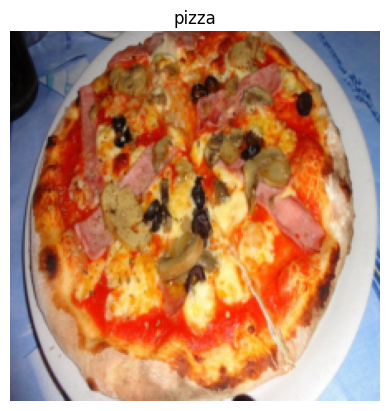

In [11]:
plt.imshow(img.permute(1, 2, 0)) 
plt.title(class_labels[label])
plt.axis(False);

# The Model:
- Input: images of shape 224x224
- Ouput: label


- Layer - takes an input, performs a function on it, returns an output.
- Block - a collection of layers.
- Architecture (or model) - a collection of blocks

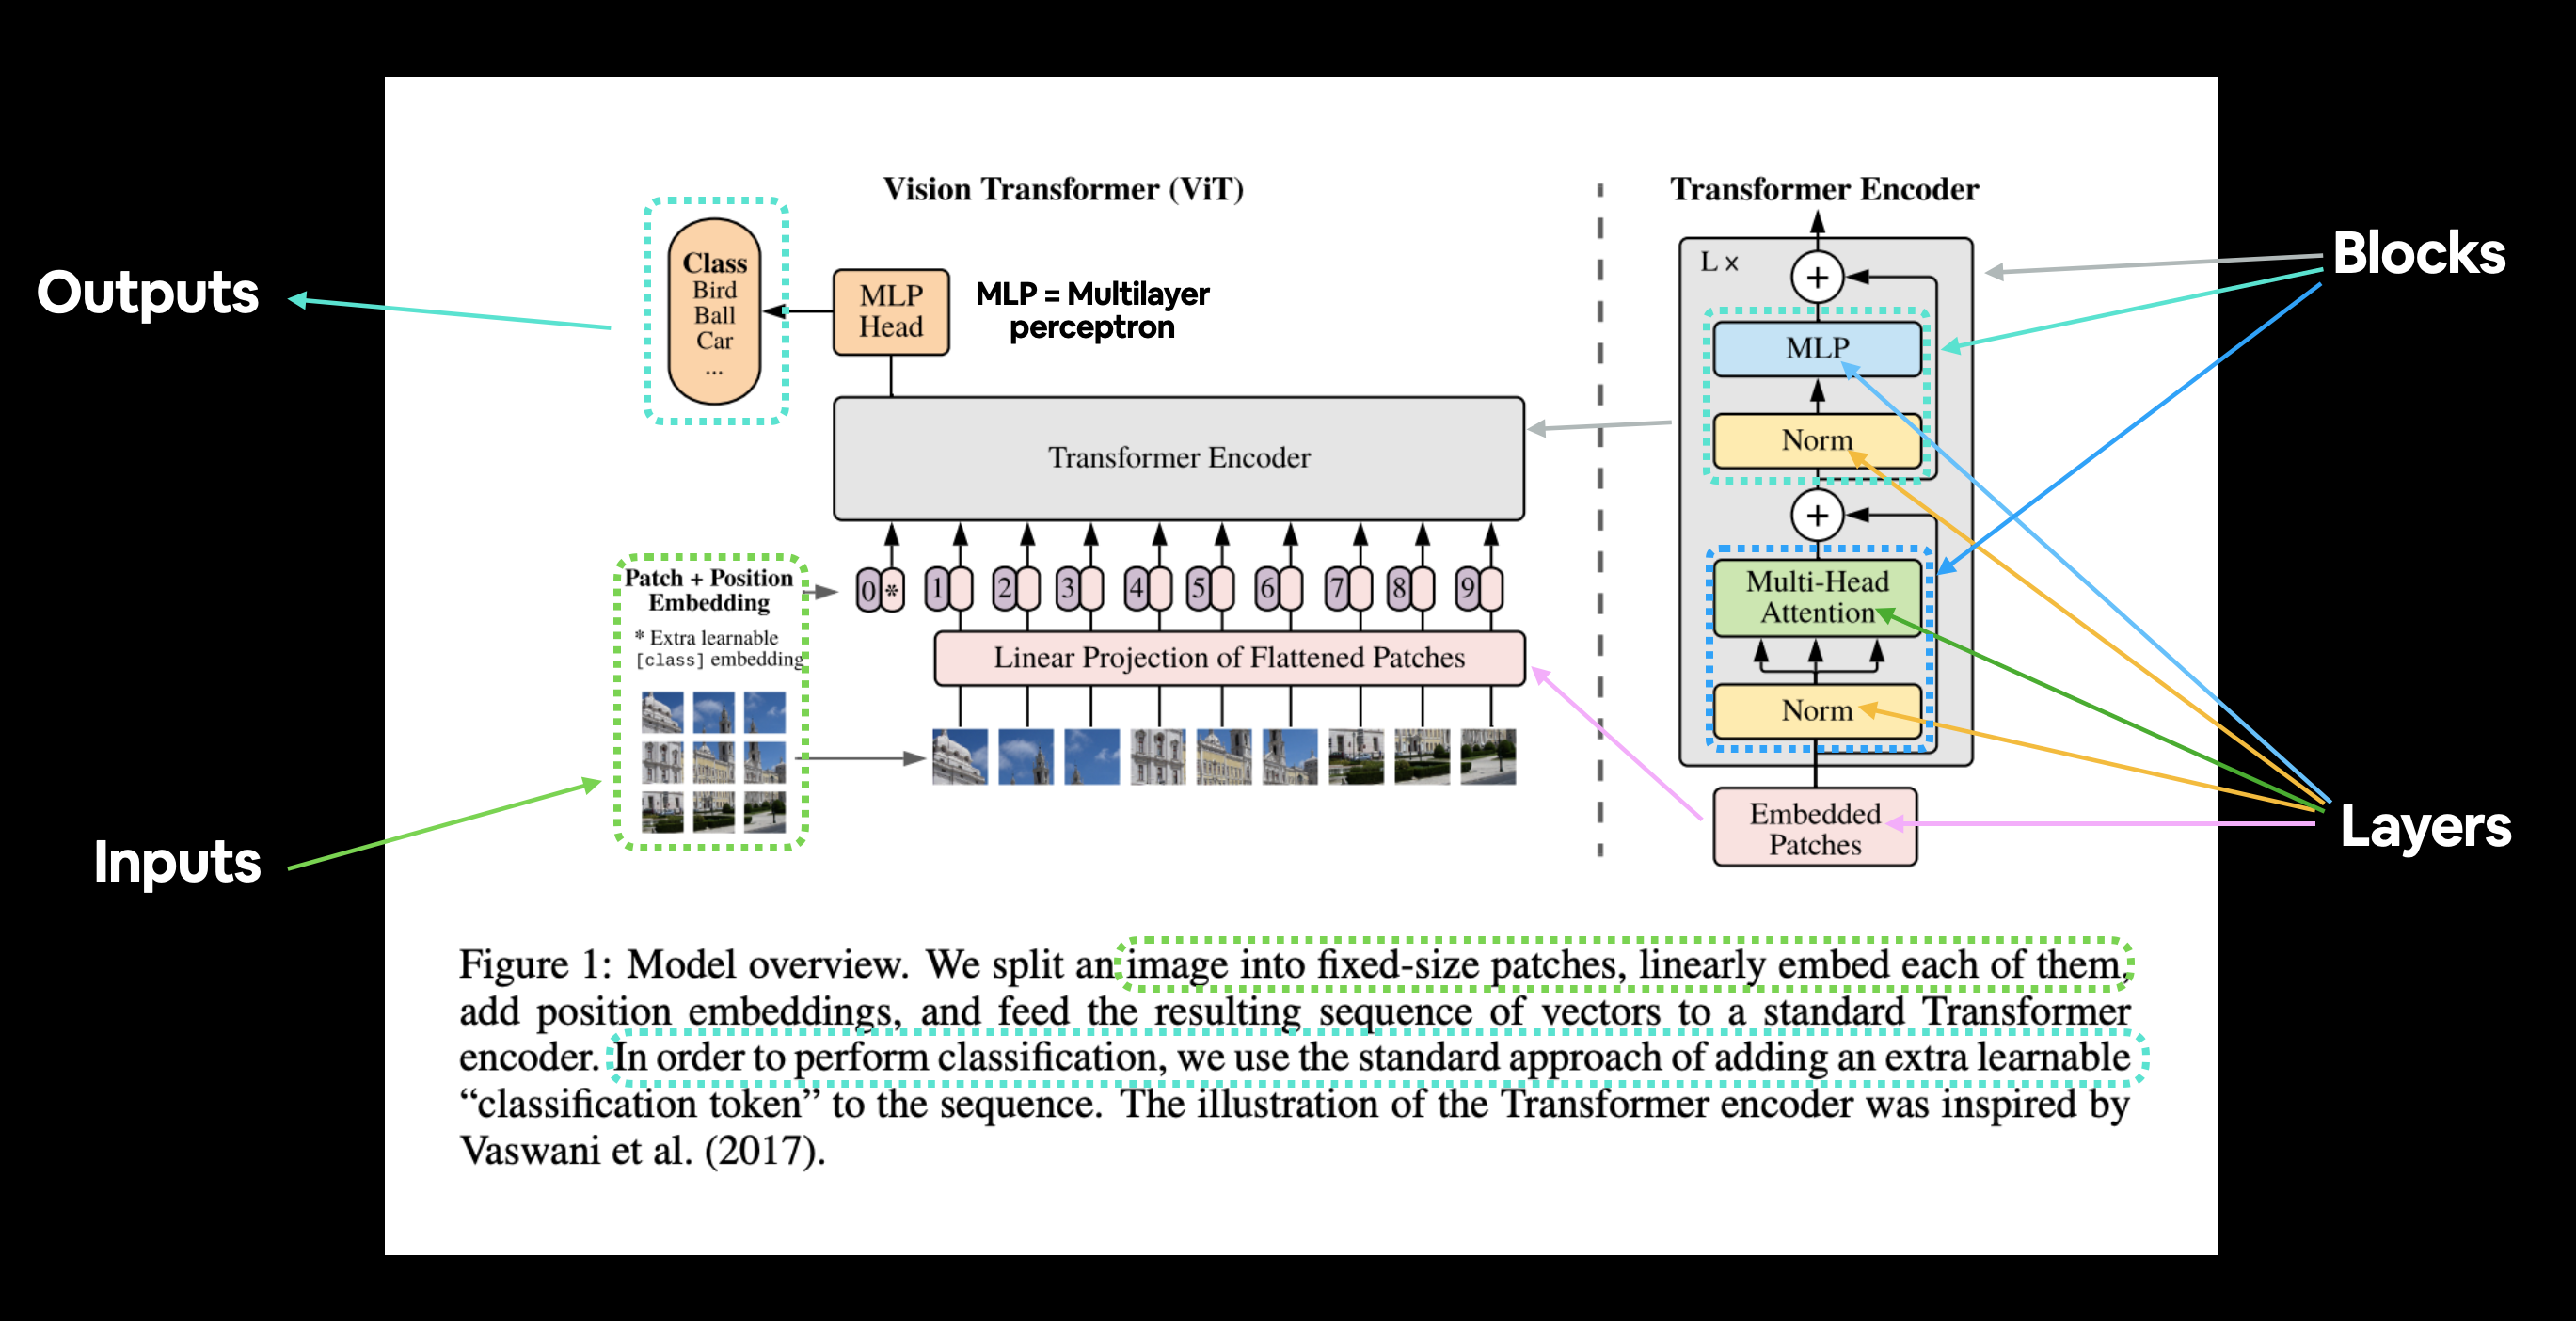

1. Patch + Position Embedding (inputs)
    > Divide the image into a sequence of patches
    > Embed into the sequence the position of each patch (their order)

2. Linear projection of flattened patches (Embedded Patches) 
    > Transform the patches into a learnable representation (vector form embedding) of the image

3. Layer Normalization
    > Apply regularization to the NN to reduce overfitting

4. Multi-Head Attention 
    > A combination of N heads of self-attention working in parallel

5. Multilayer perceptron
    > Collection of feedforward layers (Appendex B.1)
    > In the ViT paper the MLP is described to be composed of 2x Linear Layers and 1x GELU activation in-between followed by a Dropout layer (LL, GELU, LL, Drop)

6. Transformer Encoder 
    > Collection of the layers
    > They use 2 skip connections in the Transformer Encoder, represented by the "+" symbol
    > Skip connections feed the layer's input directly to the immediate layers as well as subsequent layers

7. MLP Head 
    > Output layer; assigns the features to a class output.


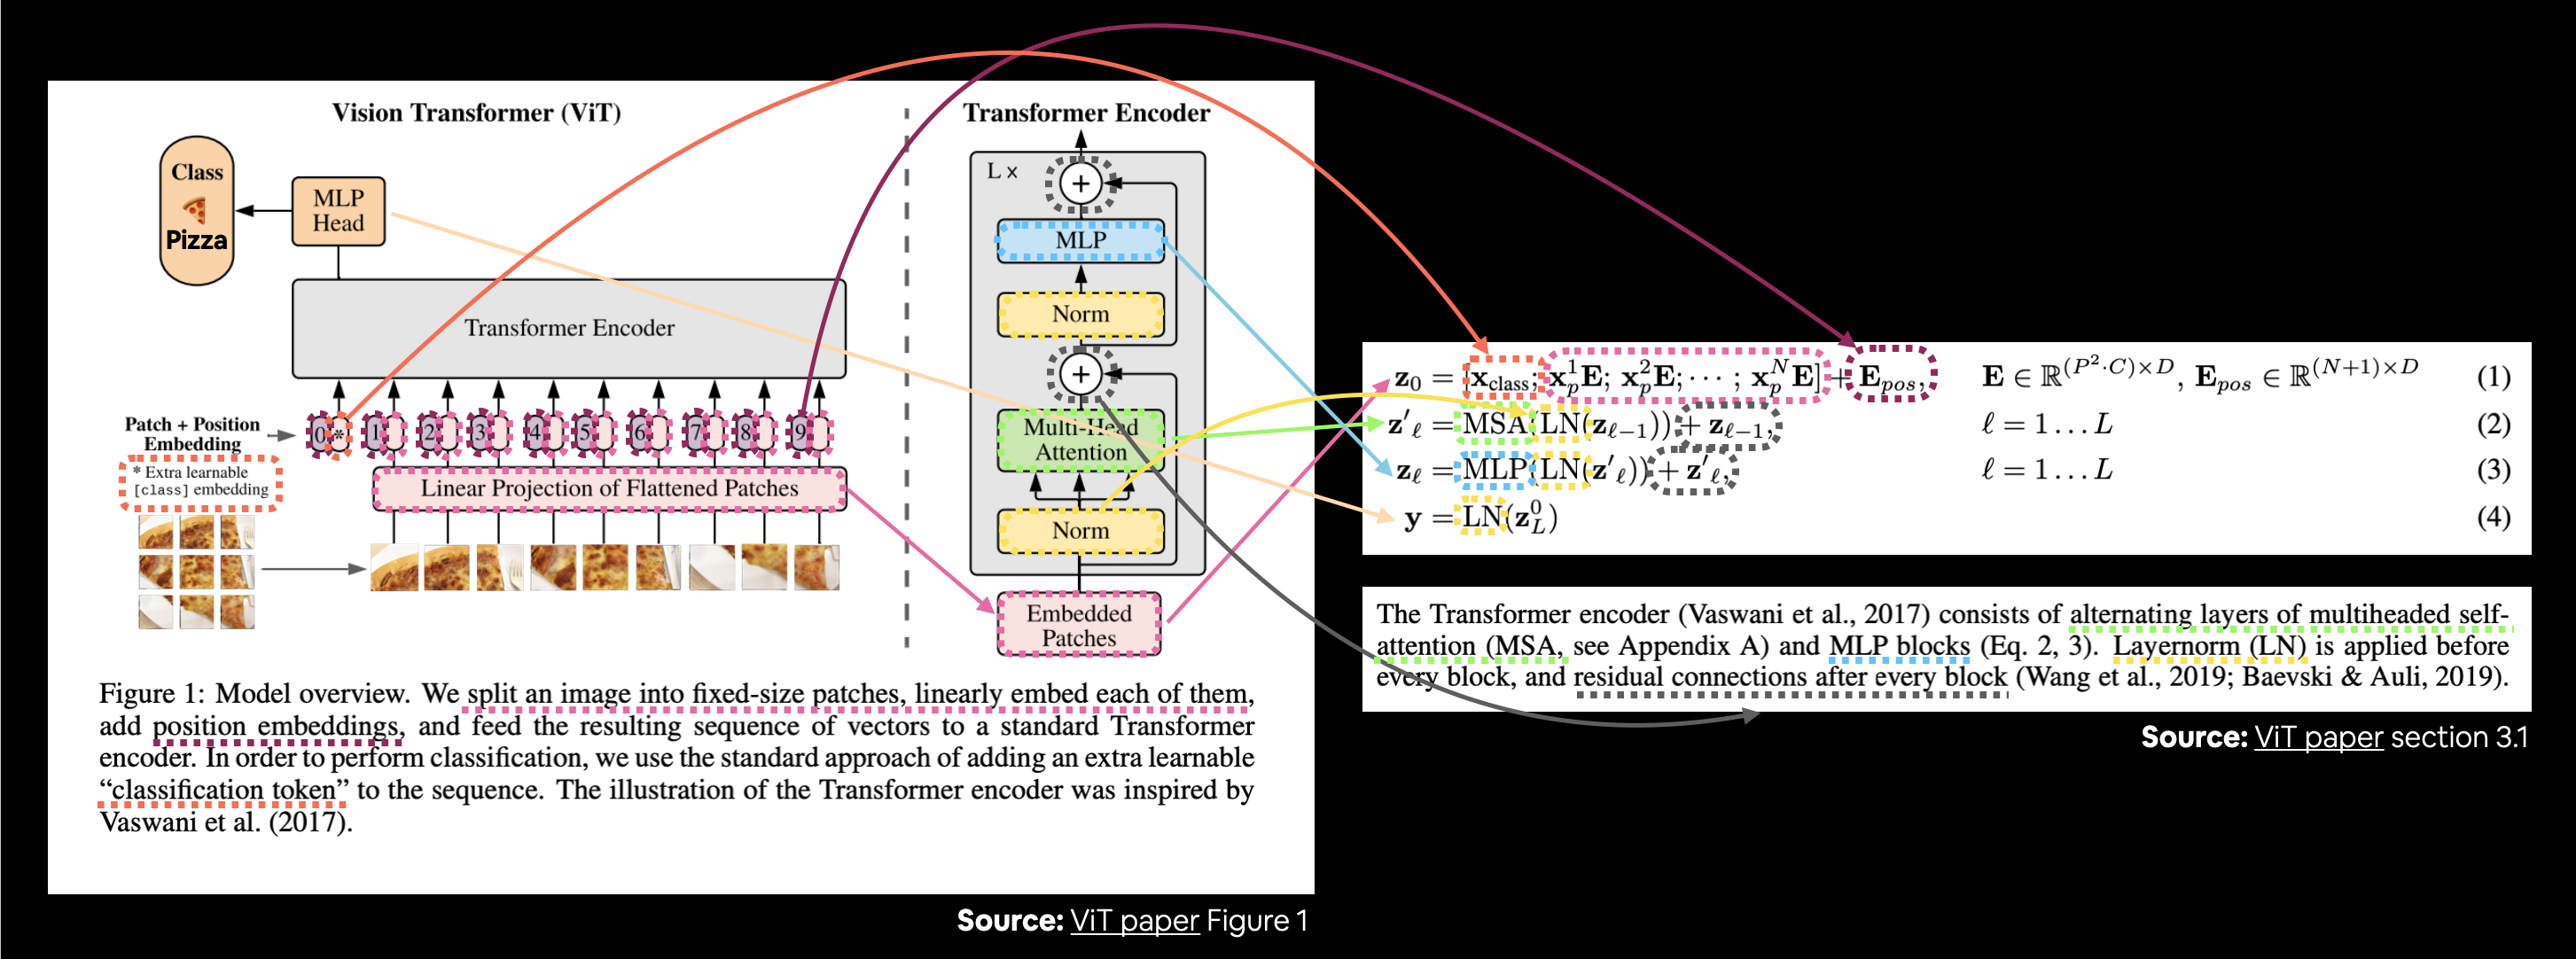

The MLP contains two layers with a GELU non-linearity.
$$
\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
$$

$$
\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L
$$
For every layer from 1 to L, there's a Multi-Head Attention layer that wraps a Normalization Layer
The addition on the end is the equivalent of adding the input to the output and forming a skip/residual connection. (https://paperswithcode.com/method/residual-connection)

x output (MSA Block) = MSA layer(LN layer(x input)) + x input

$$
\mathbf{z}_{\ell}=\operatorname{MLP}\left(\mathrm{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L
$$
For every layer from 1 to L, there's a Multilayer Perceptron layer around a Layer Norm.
And again, the addition at the end refers to a residual connection.

x output (MLP Block) = MLP layer(LN layer(x output (MSA Block))) + x output (MSA Block)

$$
\mathbf{y}=\mathrm{LN}\left(\mathbf{z}_L^0\right)
$$
Notice how in all the other equations "z" is a raw output for a particular layer, and in this fourth equation "y" is the overall output of the architecture.
So:
- $z_0$ = ouput of the patch position embedding layer
- $z^{'}_l$ = output of the MSA block, more specifically, an intermediary value ("value of z for a particular layer")
- $z_l$ = output of the MLP block

In this equation, for the last layer "L", the output y is the 0th index token of z, wrappe in a Normalization Layer

y = Linear layer(LN (x output (MLP Block)[0]))

# ViT Model Sizes
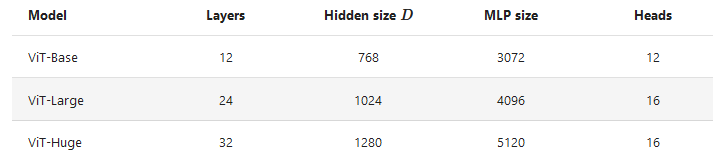

# Equation 1: Split data into patches and creating the class, position and patch embedding
$$
\mathbf{z}_0=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \dots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\mathrm{pos}}, \quad \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\mathrm{pos}} \in \mathbb{R}^{(N+1) \times D}
$$

...The Transformer uses constant latent vector size D through all of its layers, so we flatten the patches and map to D dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings... Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings...

Patch + Position Embedding
> Input (Img) -> [class token, image patch 1, ..., image patch N] + [class token position, image patch 1 position, ..., image patch N position] -> Encoded Image

To calculate the patches:
We take the height multiplied by the width to get the total image pixels, then divide by our patch size squared to match the dimensions, the result is the total number of patches, or tokens, for that image.

$N = \frac{HW}{P^{2}}$

$N = \frac{50176}{256} = 196$ tokens/patches

-> Patch Image: 224x224 -> 224x224 / N Patches of shape (RxC), 16x16 -> 196, or 224/16 = 14 patches per row, since we have a sqaure image this would also give us 14x14 = 196 total patches

To get the length of the embedding we take the patch shape (16x16) multiplied by the number of color channels: 
$P^{2}*C \to 256*$

In [12]:
h = 224
w = 224
cc = 3
p = 16

n_patches = int((h*w) / p**2)
n_patches

196

In [13]:
embd_in_shape = (h, w, cc)

embd_out_shape = (n_patches, p**2 * cc)

embd_in_shape, embd_out_shape

((224, 224, 3), (196, 768))

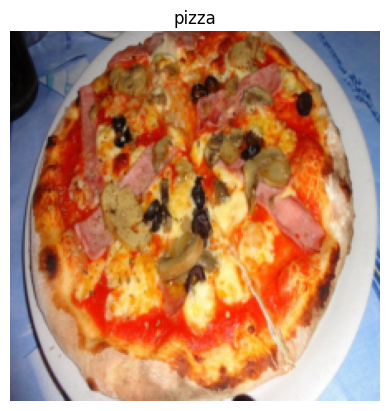

In [14]:
plt.imshow(img.permute(1, 2, 0))
plt.title(class_labels[label])
plt.axis(False);

In [15]:
img.shape

torch.Size([3, 224, 224])

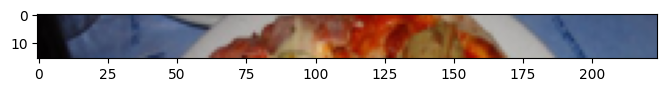

In [16]:
img_permuted = img.permute(1, 2, 0)

plt.figure(figsize=(8, 16))
plt.imshow(img_permuted[:p, :, :]);

Number of patches per row: 196
Patch size: 16 pixels x 16 pixels


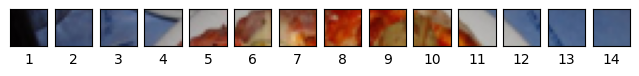

In [17]:
img_size = 224
assert img_size % p == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {n_patches}\nPatch size: {p} pixels x {p} pixels")

fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // p,
                        figsize=(8, 16),
                        sharex=True,
                        sharey=True)

for i, patch in enumerate(range(0, img_size, p)):
    axs[i].imshow(img_permuted[:p, patch:patch+p, :]); 
    axs[i].set_xlabel(i+1) 
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Patches per row: 196        
Patches per column: 196        
Total patches: 38416        
Patch size: 16 pixels x 16 pixels


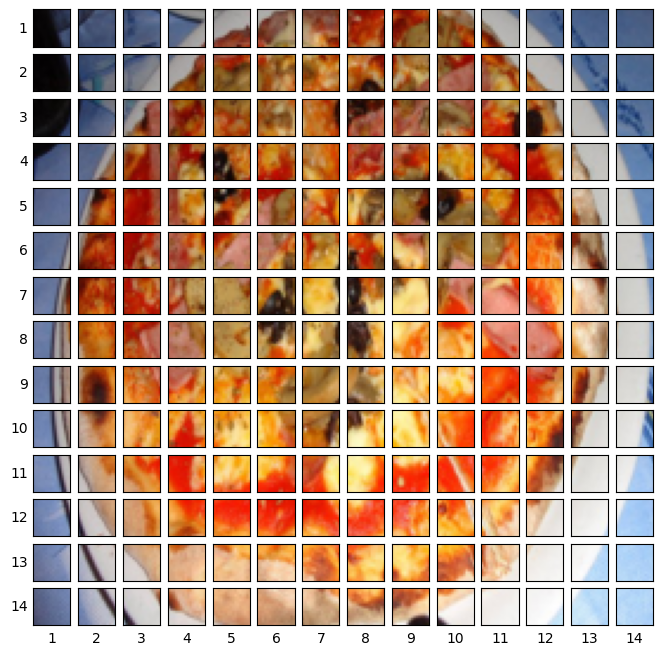

In [18]:
assert img_size % p == 0, "Image size must be divisible by patch size"
print(f"Patches per row: {n_patches}\
        \nPatches per column: {n_patches}\
        \nTotal patches: {n_patches*n_patches}\
        \nPatch size: {p} pixels x {p} pixels")

fig, axs = plt.subplots(nrows=img_size // p,
                        ncols=img_size // p,
                        figsize=(8, 8),
                        sharex=True,
                        sharey=True)

for i, patch_height in enumerate(range(0, img_size, p)):
    for j, patch_width in enumerate(range(0, img_size, p)):

        axs[i, j].imshow(img_permuted[patch_height:patch_height+p, 
                                        patch_width:patch_width+p, : ]) 

        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()
        
plt.show()

In the ViT paper, in section 3.1, it's mentioned that the patch embedding is achievable with a convolutional neural network (CNN).
> Hybrid Architecture. As an alternative to raw image patches, the input sequence can be formed from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding projection E (Eq. 1) is applied to patches extracted from a CNN feature map. As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension. The classification input embedding and position embeddings are added as described above.

The **feature map** refers to the weights/activations resulting from a convolutional layer passing over a given image.
In pytorch we can then use a Conv2d layer by setting the kernel size and stride to match our patch size so that it produces the patches.
    

In [19]:
conv = nn.Conv2d(
    in_channels=3,
    out_channels=768,
    kernel_size=16,
    stride=16,
    padding=0
)

In [20]:
conv_output = conv(img.unsqueeze(0))
conv_output.shape

torch.Size([1, 768, 14, 14])

torch.Size([1, 768, 14, 14]) -> [batch size, embedding dim, feature map height, feature map width]

Again refering to section 3.1 of the paper:
> As a special case, the patches can have spatial size 1×1, which means that the input sequence is obtained by simply flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.

In [21]:
flatten = nn.Flatten(2, 3)

In [22]:
flatten_output = flatten(conv_output)
flatten_output.shape

torch.Size([1, 768, 196])

In [23]:
reshaped_output = flatten_output.permute(0, 2, 1)
reshaped_output.shape

torch.Size([1, 196, 768])

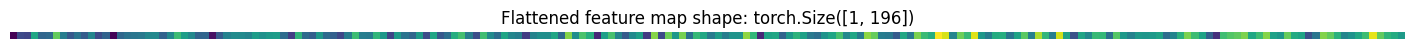

In [24]:
single_flattened_feature_map = reshaped_output[:, :, 0] # index: (batch size, number of patches, embedding dimension)

plt.figure(figsize=(18, 18))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [25]:
single_flattened_feature_map, single_flattened_feature_map.requires_grad, single_flattened_feature_map.shape

(tensor([[-0.0738,  0.0497,  0.0401,  0.2503,  0.1080,  0.1149,  0.3459,  0.1592,
           0.0800,  0.1378,  0.0857,  0.1761,  0.0514,  0.0978, -0.0681,  0.1102,
           0.1349,  0.1411,  0.1483,  0.1807,  0.1824,  0.0984,  0.1816,  0.3029,
           0.2320,  0.1818,  0.1002,  0.1042, -0.0498,  0.0847,  0.1688,  0.1903,
           0.1888,  0.1743,  0.2293,  0.2038,  0.2212,  0.2290,  0.1204,  0.0279,
           0.2829,  0.1164,  0.0929,  0.2183,  0.1174,  0.0942,  0.0422,  0.1538,
           0.3034,  0.1610,  0.1538,  0.2865,  0.2162,  0.0405,  0.2258,  0.1349,
           0.1065,  0.2258,  0.0543,  0.2485,  0.0769,  0.1247,  0.2673,  0.3110,
           0.1601,  0.0582,  0.3064,  0.1913,  0.1243,  0.2476,  0.1786,  0.1613,
           0.0243,  0.1705,  0.1997,  0.1973,  0.2502,  0.1132,  0.3741,  0.1952,
           0.3182,  0.2697, -0.0121,  0.2360,  0.3153,  0.1754,  0.0847,  0.1866,
           0.2365,  0.0209,  0.3742,  0.0478,  0.3526,  0.2174,  0.3630,  0.1279,
           0.293

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768) -> None:
        super(PatchEmbedding, self).__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(2, 3)

    def forward(self, x):
        resolution = x.shape[-1]
        patch_size = self.conv.kernel_size[0]
        assert resolution % patch_size == 0, f"Input image size must be divisble by patch size. \nInput image shape: {resolution} | Patch size: {patch_size}"

        x = self.flatten(self.conv(x))
        return x.permute(0, 2, 1)

In [27]:
from torchinfo import summary

In [28]:
rand_img = (1, 3, 224, 224)
rand_img_error = (1, 3, 250, 250)

In [29]:
summary(PatchEmbedding(),
        input_size=rand_img,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (conv)                          [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [30]:
# summary(PatchEmbedding(),
#         input_size=rand_img_error,
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [31]:
patchify = PatchEmbedding(3, 16, 768)
print(f"Input image shape: {img.unsqueeze(0).shape}")
patch_embedded_image = patchify(img.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [32]:
print(patch_embedded_image)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.0458, -0.0597, -0.0980,  ..., -0.0912, -0.0216, -0.0172],
         [-0.1241,  0.0253, -0.1514,  ..., -0.0385, -0.2468, -0.1284],
         [-0.1505,  0.1185, -0.1460,  ...,  0.0079, -0.2880, -0.1595],
         ...,
         [-0.3703,  0.2760, -0.5325,  ...,  0.0077, -0.6921, -0.5511],
         [-0.3474,  0.2348, -0.3605,  ...,  0.0298, -0.5864, -0.5097],
         [-0.3567,  0.2259, -0.4011,  ...,  0.0300, -0.6025, -0.4624]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Class Token Embedding
Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $(z^{0}_{0} = x_text{class})$, whose state at the output of the Transformer encoder $(z^{0}_{L})$ serves as the image representation y (Eq. 4).

Note: BERT (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a [ class ] token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.

In [33]:
batch_size = patch_embedded_image.shape[0]
embedding_dim = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dim), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) 

print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [34]:
img_class_embedded = torch.cat((class_token, patch_embedded_image), dim=1) 

print(img_class_embedded)
print(f"Sequence of patch embeddings with class token prepended shape: {img_class_embedded.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.0458, -0.0597, -0.0980,  ..., -0.0912, -0.0216, -0.0172],
         [-0.1241,  0.0253, -0.1514,  ..., -0.0385, -0.2468, -0.1284],
         ...,
         [-0.3703,  0.2760, -0.5325,  ...,  0.0077, -0.6921, -0.5511],
         [-0.3474,  0.2348, -0.3605,  ...,  0.0298, -0.5864, -0.5097],
         [-0.3567,  0.2259, -0.4011,  ...,  0.0300, -0.6025, -0.4624]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


# Position Embedding
Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In [35]:
number_of_patches = int((h * w) / p**2)

embedding_dimension = img_class_embedded.shape[2]

position_embedding = nn.Parameter(torch.ones(1, number_of_patches + 1, embedding_dimension), requires_grad=True)

print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [36]:
patch_and_position_embedding = img_class_embedded + position_embedding

# Equation 1 - All together

In [37]:
patch_size = 16

print(f"Image tensor: {img.shape}")
height, width = img.shape[1], img.shape[2]

x = img.unsqueeze(0)
print(f"Input: {x.shape}")

patch_embd_layer = PatchEmbedding(3, patch_size, 768)

patch_embd = patch_embd_layer(x)
print(f"Patch + Embedding: {patch_embd.shape}")

batches = patch_embd.shape[0]
embd_dim = patch_embd.shape[-1]

class_token = nn.Parameter(torch.ones(batch_size, 1, embd_dim),
                           requires_grad=True)
print(f"Class Token: {class_token.shape}")

embd_class_token = torch.cat((class_token, patch_embd), dim=1)
print(f"Patch embedding wih class token: {embd_class_token.shape}")

n_patches = int((height * width) / patch_size**2)

pos_embd = nn.Parameter(torch.ones(1, n_patches+1, embd_dim),
                        requires_grad=True)

patch_pos_embd = embd_class_token + pos_embd
print(f"Patch + Position Embedding: {patch_pos_embd.shape}")

Image tensor: torch.Size([3, 224, 224])
Input: torch.Size([1, 3, 224, 224])
Patch + Embedding: torch.Size([1, 196, 768])
Class Token: torch.Size([1, 1, 768])
Patch embedding wih class token: torch.Size([1, 197, 768])
Patch + Position Embedding: torch.Size([1, 197, 768])


# Equation 2: Multi-Head Attention (MSA)

$\mathbf{z}_{\ell}^{\prime}=\operatorname{MSA}\left(\mathbf{L N}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, \quad \ell=1 \ldots L \\$

## Multi-Head Self-Attention
$$
\begin{gathered}
\text { MultiHead }(\mathbf{Q}, \mathbf{K}, \mathbf{V})=\left[\text { head }_1, \ldots, \text { head }_h\right] \mathbf{W}_{\mathbf{0}} \\
\text { where head }_i=\text { Attention }\left(\mathbf{Q} \mathbf{W}_i^Q, \mathbf{K} \mathbf{W}_i^K, \mathbf{V} \mathbf{W}_i^V\right)
\end{gathered}
$$

### Layer Normalization
$$
\begin{gathered}
\mu^l=\frac{1}{H} \sum_{i=1}^H a_i^l \\
\sigma^l=\sqrt{\frac{1}{H} \sum_{i=1}^H\left(a_i^l-\mu^l\right)^2}
\end{gathered}
$$

In [38]:
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attention_dropout: float = 0.0):
        super(MultiHeadSelfAttentionBlock, self).__init__()

        self.ln = nn.LayerNorm(embedding_dim)

        self.msa = nn.MultiheadAttention(embedding_dim, num_heads, attention_dropout, batch_first=True)

    def forward(self, x):
        x = self.ln(x)
        output, _ = self.msa(query=x, key=x, value=x, need_weights=False)

        return output

In [39]:
msa_block = MultiHeadSelfAttentionBlock()

msa_output = msa_block(patch_pos_embd)

patch_pos_embd.shape, msa_output.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

# Equation 3: Multilayer Perceptron (MLP)
$$
\mathbf{z}_{\ell}=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, \quad \ell=1 \ldots L
$$

"General MLP structure"
> linear layer -> non-linear layer -> linear layer -> non-linear layer

In the ViT paper we have the MLP structure defined for us in section 3.1:
> The MLP contains two layers with a GELU non-linearity.
Which basically means two linear layers and a GELU (Gaussian Error Linear Units) non-linear activation function

Further on in the paper, at appendinx B.1 (training) we are told that:
> Table 3 summarizes our training setups for our different models. ...**Dropout, when used, is applied after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

So every linear layer in the MLP block has a dropout layer, and the values for these are shown in Table 3 (droptout = 0.1)

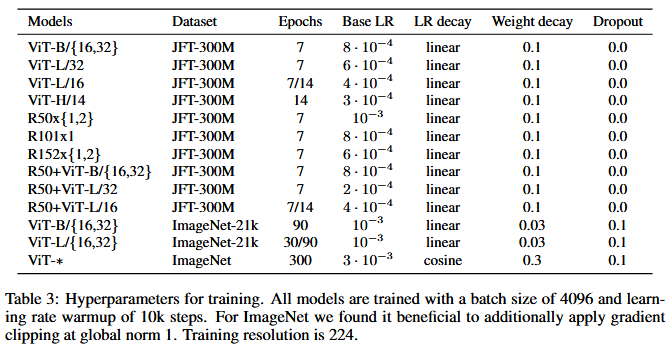

With this in mind, our MLP will look like:
> layer norm -> linear layer -> non-linear layer (GELU) -> dropout -> linear layer -> dropout

The hyperparameters for the linear layers can be found in Table 1, as the MLP size is the number of hidden units between the linear layers, and the hidden size D is the output size of our MLP block

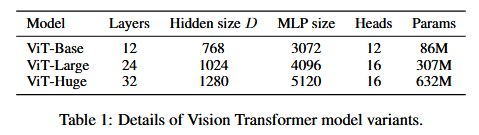

In [40]:
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: int = 0.1):
        super(MLPBlock, self).__init__()

        self.ln = nn.LayerNorm(embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(self.ln(x))

In [41]:
mlp_block = MLPBlock()

mlp_output = mlp_block(msa_output)

msa_output.shape, mlp_output.shape

(torch.Size([1, 197, 768]), torch.Size([1, 197, 768]))

# The Transformer Encoder
Multi-Head Self-Attention Block + Multi-Layer Perceptron

Again section 3.1 describes the transformer encoder structure:
> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).

INPUT -> MSA -> MSA OUT + INPUT -> MLP -> MLP OUT + MSA OUT + INPUT -> ...

LN -> MSA -> RES -> LN -> MLP -> RES

In [42]:
class TransfomerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, mlp_size: int = 3072, mlp_dropout: float = 0.1, attn_dropout: float = 0.0):
        super(TransfomerEncoderBlock, self).__init__()

        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

    def forward(self, x):
        msa_out = self.msa_block(x) + x
        mlp_out = self.mlp_block(msa_out) + x
        return mlp_out

In [43]:
transformer_block = TransfomerEncoderBlock()

summary(model=transformer_block,
        input_size=(1, 197, 768),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

c:\Users\g4bri\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransfomerEncoderBlock (TransfomerEncoderBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (msa)                    --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (ln)                              [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

In [44]:
torch_transformer_encoder = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                        nhead=12, 
                                                        dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                        dropout=0.1, 
                                                        activation="gelu", # GELU non-linear activation
                                                        batch_first=True, 
                                                        norm_first=True) # Normalize first or after MSA/MLP layers?

torch_transformer_encoder

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [45]:
summary(model=torch_transformer_encoder,
        input_size=(1, 197, 768), 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [46]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, embedding_dim: int = 768):
        super(PatchEmbedding, self).__init__()

        self.conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=embedding_dim,
            kernel_size=patch_size,
            stride=patch_size,
            padding=0
        )

        self.flatten = nn.Flatten(2, 3)

    def forward(self, x):
        resolution = x.shape[-1]
        patch_size = self.conv.kernel_size[0]
        assert resolution % patch_size == 0, f"Input image size must be divisble by patch size. \nInput image shape: {resolution} | Patch size: {patch_size}"

        x = self.flatten(self.conv(x))
        return x.permute(0, 2, 1)
    
class MultiHeadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, attention_dropout: float = 0.0):
        super(MultiHeadSelfAttentionBlock, self).__init__()

        self.ln = nn.LayerNorm(embedding_dim)

        self.msa = nn.MultiheadAttention(embedding_dim, num_heads, attention_dropout, batch_first=True)

    def forward(self, x):
        x = self.ln(x)
        output, _ = self.msa(query=x, key=x, value=x, need_weights=False)

        return output
    
class MLPBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, mlp_size: int = 3072, dropout: int = 0.1):
        super(MLPBlock, self).__init__()

        self.ln = nn.LayerNorm(embedding_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.mlp(self.ln(x))
    
class TransfomerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim: int = 768, num_heads: int = 12, mlp_size: int = 3072, mlp_dropout: float = 0.1, attn_dropout: float = 0.0):
        super(TransfomerEncoderBlock, self).__init__()

        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim, num_heads, attn_dropout)

        self.mlp_block = MLPBlock(embedding_dim, mlp_size, mlp_dropout)

    def forward(self, x):
        msa_out = self.msa_block(x) + x
        mlp_out = self.mlp_block(msa_out) + x
        return mlp_out

class ViT_Scratch(nn.Module):
    def __init__(self, 
                 img_szie:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 n_transformer_layers:int=12, 
                 d_model:int=768, 
                 nheads:int=12, 
                 dim_feedforward:int=3072, 
                 dropout:float=0.1, 
                 nclasses:int=1000):
        super(ViT_Scratch, self).__init__()

        assert img_szie % patch_size == 0, f"The image (input) size must be divisible by the patch size. \nReceived: Input Size {img_szie} | Patch Size {patch_size}"

        self.npatches = (img_szie * img_szie) // patch_size**2

        self.class_embd = nn.Parameter(data=torch.randn(1, 1, d_model), requires_grad=True)

        self.pos_embd = nn.Parameter(data=torch.randn(1, self.npatches+1, d_model), requires_grad=True)

        self.embd_dropout = nn.Dropout(dropout)

        self.patch_embd = PatchEmbedding(in_channels, patch_size, d_model)

        self.transformer_encoder_blocks = nn.Sequential(*[TransfomerEncoderBlock(d_model, nheads, dim_feedforward, dropout, dropout) for _ in range(n_transformer_layers)])
        
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, nclasses)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embd.expand(batch_size, -1, -1)
        x = self.patch_embd(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.pos_embd + x
        x = self.embd_dropout(x)
        x = self.transformer_encoder_blocks(x)
        x = self.classifier(x[:, 0])
        return x


In [47]:
class ViT(nn.Module):
    def __init__(self, 
                 img_szie:int=224, 
                 in_channels:int=3, 
                 patch_size:int=16, 
                 n_transformer_layers:int=12, 
                 d_model:int=768, 
                 nheads:int=12, 
                 dim_feedforward:int=3072, 
                 dropout:float=0.1, 
                 nclasses:int=1000):
        super(ViT, self).__init__()

        assert img_szie % patch_size == 0, f"The image (input) size must be divisible by the patch size. \nReceived: Input Size {img_szie} | Patch Size {patch_size}"

        self.npatches = (img_szie * img_szie) // patch_size**2

        self.class_embd = nn.Parameter(data=torch.randn(1, 1, d_model), requires_grad=True)

        self.pos_embd = nn.Parameter(data=torch.randn(1, self.npatches+1, d_model), requires_grad=True)

        self.embd_dropout = nn.Dropout(dropout)

        self.patch_embd = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=d_model,
                kernel_size=patch_size,
                stride=patch_size,
                padding=0
            ),
            nn.Flatten(2, 3)
        ) 
        self.transformer_encoder_blocks = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model, nheads, dim_feedforward, dropout, activation="gelu", batch_first=True, norm_first=True), n_transformer_layers)
        
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, nclasses)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embd.expand(batch_size, -1, -1)
        x = self.patch_embd(x).permute(0, 2, 1)
        x = torch.cat((class_token, x), dim=1)
        x = self.pos_embd + x
        x = self.embd_dropout(x)
        x = self.transformer_encoder_blocks(x)
        x = self.mlp_head(x[:, 0])
        return x


In [48]:
random_image_tensor = torch.randn(1, 3, 224, 224)

vit_scratch = ViT_Scratch(nclasses=len(class_labels))
vit_scratch(random_image_tensor)

tensor([[-0.7577, -0.5959, -0.2455]], grad_fn=<AddmmBackward0>)

In [49]:
random_image_tensor = torch.randn(1, 3, 224, 224)

vit = ViT(nclasses=len(class_labels))
vit(random_image_tensor)

c:\Users\g4bri\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


tensor([[-0.2411, -0.3136,  0.0669]], grad_fn=<AddmmBackward0>)

In [50]:
summary(
    model=vit_scratch,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT_Scratch (ViT_Scratch)                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embd)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (conv)                                    [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embd_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder_blocks)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransfomerEncoderBlock (0)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    │ 

In [51]:
summary(
    model=vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"],
    verbose=1
)

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─Sequential (patch_embd)                               [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embd_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder_blocks)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                               [1, 3, 224, 224]     [1, 3]               152,064              True
├─Sequential (patch_embd)                               [1, 3, 224, 224]     [1, 768, 196]        --                   True
│    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (1)                                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embd_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─TransformerEncoder (transformer_encoder_blocks)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─ModuleList (layers)                              --                   --                   --                   True
│    │ 

# Optimizer
The ViT paper mentions, on section 4.1, on Training and Fine-tuning states:
> Training & Fine-tuning. We train all models, including ResNets, using Adam (Kingma & Ba, 2015 ) with β1=0.9,β2=0.999, a batch size of 4096 and apply a high weight decay of 0.1, which we found to be useful for transfer of all models (Appendix D.1 shows that, in contrast to common practices, Adam works slightly better than SGD for ResNets in our setting).

In [52]:
optimizer = torch.optim.Adam(params=vit_scratch.parameters(),
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

loss_fn = nn.CrossEntropyLoss()

results_scratch = utils.train(model=vit_scratch, 
                      train_dataloader=dl_train, 
                      test_dataloader=dl_test, 
                      optimizer=optimizer, 
                      loss_fn=loss_fn, 
                      epochs=10, 
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.1102 | train_acc: 0.2969 | test_loss: 1.0835 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.3723 | train_acc: 0.3945 | test_loss: 2.7619 | test_acc: 0.1979
Epoch: 3 | train_loss: 1.4042 | train_acc: 0.4336 | test_loss: 1.3757 | test_acc: 0.5417
Epoch: 4 | train_loss: 1.3389 | train_acc: 0.2656 | test_loss: 1.0233 | test_acc: 0.5417
Epoch: 5 | train_loss: 1.1687 | train_acc: 0.3984 | test_loss: 1.3675 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1467 | train_acc: 0.4219 | test_loss: 1.1837 | test_acc: 0.2604
Epoch: 7 | train_loss: 1.1670 | train_acc: 0.4023 | test_loss: 1.2730 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.2663 | train_acc: 0.2930 | test_loss: 1.1056 | test_acc: 0.2604
Epoch: 9 | train_loss: 1.0896 | train_acc: 0.4023 | test_loss: 1.2213 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.1430 | train_acc: 0.2930 | test_loss: 1.1384 | test_acc: 0.2604


In [53]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=3e-3, 
                             betas=(0.9, 0.999), 
                             weight_decay=0.3) 

loss_fn = nn.CrossEntropyLoss()

results = utils.train(model=vit, 
                      train_dataloader=dl_train, 
                      test_dataloader=dl_test, 
                      optimizer=optimizer, 
                      loss_fn=loss_fn, 
                      epochs=10, 
                      device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 3.8496 | train_acc: 0.3086 | test_loss: 1.3526 | test_acc: 0.1979
Epoch: 2 | train_loss: 1.5069 | train_acc: 0.2930 | test_loss: 1.9404 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.5412 | train_acc: 0.2695 | test_loss: 1.5819 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.2473 | train_acc: 0.2734 | test_loss: 1.5631 | test_acc: 0.1979
Epoch: 5 | train_loss: 1.1951 | train_acc: 0.3633 | test_loss: 1.3846 | test_acc: 0.1979
Epoch: 6 | train_loss: 1.1644 | train_acc: 0.3008 | test_loss: 1.0286 | test_acc: 0.5417
Epoch: 7 | train_loss: 1.1497 | train_acc: 0.4062 | test_loss: 1.3119 | test_acc: 0.1979
Epoch: 8 | train_loss: 1.1898 | train_acc: 0.3047 | test_loss: 1.0411 | test_acc: 0.5417
Epoch: 9 | train_loss: 1.2629 | train_acc: 0.2812 | test_loss: 1.3435 | test_acc: 0.1979
Epoch: 10 | train_loss: 1.3602 | train_acc: 0.2969 | test_loss: 1.1439 | test_acc: 0.2604


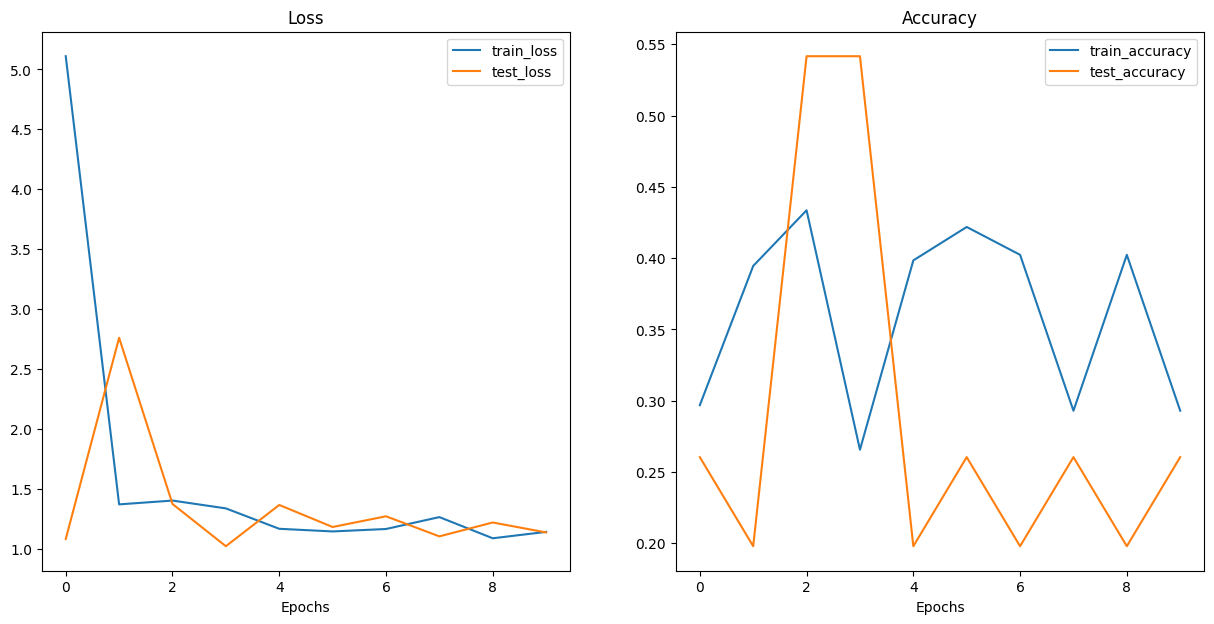

In [54]:
utils.plot_loss_curves(results_scratch)

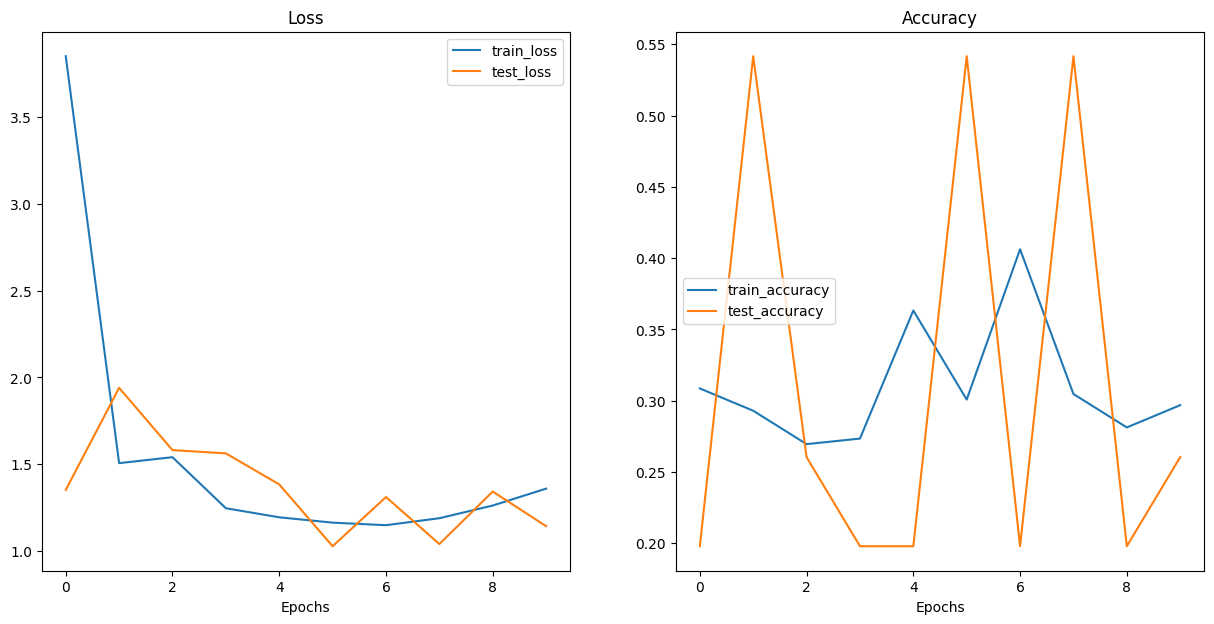

In [55]:
utils.plot_loss_curves(results)

# Using a pre-trained model for transfer learning

In [56]:
vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

pretrained_vit = torchvision.models.vit_b_16(weights=vit_weights).to(device)

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_labels)).to(device)
pretrained_vit

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to C:\Users\g4bri/.cache\torch\hub\checkpoints\vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 67.8MB/s] 


VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [57]:
summary(
    model=pretrained_vit,
    input_size=(1, 3, 224, 224),
    col_names=["input_size", "output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [58]:
pretrained_vit_transforms = vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


In [59]:
train_dl_pretrained, test_dl_pretrained, class_labels = utils.create_dataloaders(train_dir=train_dir,
                                                                                test_dir=test_dir,
                                                                                transform=pretrained_vit_transforms,
                                                                                batch_size=32)

2024-05-08 16:04:36,353 - [INFO] - Successfully created train and test dataloaders


In [60]:
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)

loss_fn = torch.nn.CrossEntropyLoss()

results_pretrained = utils.train(model=pretrained_vit,
                                    train_dataloader=train_dl_pretrained,
                                    test_dataloader=test_dl_pretrained,
                                    optimizer=optimizer,
                                    loss_fn=loss_fn,
                                    epochs=10,
                                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.8342 | train_acc: 0.6289 | test_loss: 0.4931 | test_acc: 0.8674
Epoch: 2 | train_loss: 0.3387 | train_acc: 0.9258 | test_loss: 0.2965 | test_acc: 0.9072
Epoch: 3 | train_loss: 0.2484 | train_acc: 0.9453 | test_loss: 0.2548 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.1640 | train_acc: 0.9648 | test_loss: 0.2705 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.1467 | train_acc: 0.9727 | test_loss: 0.2689 | test_acc: 0.9081
Epoch: 6 | train_loss: 0.1801 | train_acc: 0.9727 | test_loss: 0.2634 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.1056 | train_acc: 0.9727 | test_loss: 0.2806 | test_acc: 0.9186
Epoch: 8 | train_loss: 0.1241 | train_acc: 0.9727 | test_loss: 0.2545 | test_acc: 0.9081
Epoch: 9 | train_loss: 0.0956 | train_acc: 0.9805 | test_loss: 0.2136 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.0728 | train_acc: 0.9844 | test_loss: 0.1980 | test_acc: 0.9280


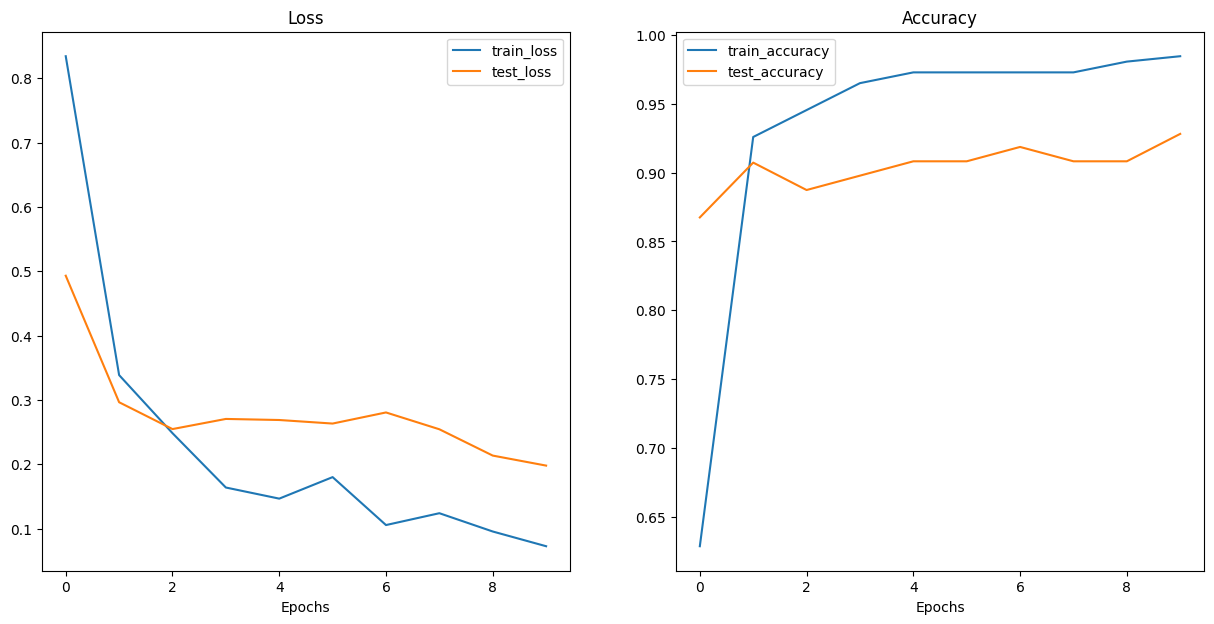

In [61]:
utils.plot_loss_curves(results_pretrained)